In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# convert MNIST images into a tensor of 4-Dimensions (# of images, height, width, color)
transform = transforms.ToTensor()

In [3]:
# Train data
train_data = datasets.MNIST(root='cnn_data', 
                            train=True, 
                            download=True, 
                            transform=transform)

In [4]:
# Test data
test_data = datasets.MNIST(root='cnn_data', 
                            train=False, 
                            download=True, 
                            transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Create a small batch size for images : say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
#Define CNN model
#Describe convolutional layer and what's it's doing (2 convolutional layers)
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1) 

In [9]:
# Grab 1 MNIST record
for i , (X_train, y_train) in enumerate(train_data):
    break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
x = X_train.view(1,1,28,28)

In [12]:
x.shape

torch.Size([1, 1, 28, 28])

In [13]:
x = F.relu(conv1(x))

In [14]:
# 1 is the image number
# 6 is the number of filters as 
# 26 x 26 is the image size without the padding
x.shape

torch.Size([1, 6, 26, 26])

In [15]:
# pass thru a pooling layer
# kernal of 2  and strid of 2
x = F.max_pool2d(x,2,2)

In [16]:
x.shape # 26/2 = 13

torch.Size([1, 6, 13, 13])

In [17]:
# convolutional layer
x = F.relu(conv2(x))

In [18]:
x.shape # no padding was set so we are loosing 2 pix

torch.Size([1, 16, 11, 11])

In [19]:
x = F.max_pool2d(x,2,2)

In [20]:
x.shape # 11/2 = 5.5 but we have to round down coz we can't reinvent data.


torch.Size([1, 16, 5, 5])

In [21]:
# model class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)

        #fully connected layers
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120 , 85)
        self.fc3 = nn.Linear(85, 10)


    def forward(self, X):
        # 1st pass
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        # 2nt pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)

        #Re-View to flatten it out
        X = X.view(-1,16*5*5)

        # Fully Connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X,dim=1)

In [22]:
# Creating a manual seed
torch.manual_seed(41)

# Creat an Instance of the model
model = ConvolutionalNetwork()

In [23]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=85, bias=True)
  (fc3): Linear(in_features=85, out_features=10, bias=True)
)

In [24]:
# Loss function optimizer and criterion 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # smaller the lr more time it takes

In [25]:
import time
start_time = time.time()

# Create variables to Track Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For loop for Epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0


    # Train
    for b,(X_train, y_train) in enumerate(train_loader):
        b += 1 # the batch number
        y_pred = model(X_train) # get predicted values from the training set. 
        loss = criterion(y_pred,y_train) # calculating the difference

        predicted = torch.max(y_pred.data,1)[1] # add the correct predictions
        batch_corr = (predicted == y_train).sum() #how many we got corrected from this batch
        trn_corr += batch_corr # keep track as we go along
        
        #Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print results
        if b%600 == 0:
            print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test
    with torch.no_grad(): # we don't want to update the network at this point
        for b,(X_test,y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum() #T=1 F=0
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Traing Took:{total/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.22181148827075958
Epoch: 0 Batch: 1200 Loss: 0.037741731852293015
Epoch: 0 Batch: 1800 Loss: 0.009244666434824467
Epoch: 0 Batch: 2400 Loss: 0.01033247634768486
Epoch: 0 Batch: 3000 Loss: 0.013654719106853008
Epoch: 0 Batch: 3600 Loss: 0.2322227656841278
Epoch: 0 Batch: 4200 Loss: 0.12155045568943024
Epoch: 0 Batch: 4800 Loss: 0.026502709835767746
Epoch: 0 Batch: 5400 Loss: 0.014064577408134937
Epoch: 0 Batch: 6000 Loss: 0.1005055159330368
Epoch: 1 Batch: 600 Loss: 0.002832434605807066
Epoch: 1 Batch: 1200 Loss: 0.0016832707915455103
Epoch: 1 Batch: 1800 Loss: 0.0036604113411158323
Epoch: 1 Batch: 2400 Loss: 0.029183443635702133
Epoch: 1 Batch: 3000 Loss: 0.0010616349754855037
Epoch: 1 Batch: 3600 Loss: 0.034600287675857544
Epoch: 1 Batch: 4200 Loss: 0.0008950062328949571
Epoch: 1 Batch: 4800 Loss: 0.006129898130893707
Epoch: 1 Batch: 5400 Loss: 0.0017226729542016983
Epoch: 1 Batch: 6000 Loss: 0.003495133714750409
Epoch: 2 Batch: 600 Loss: 0.0035183248110115

In [26]:
type(test_losses[0])

torch.Tensor

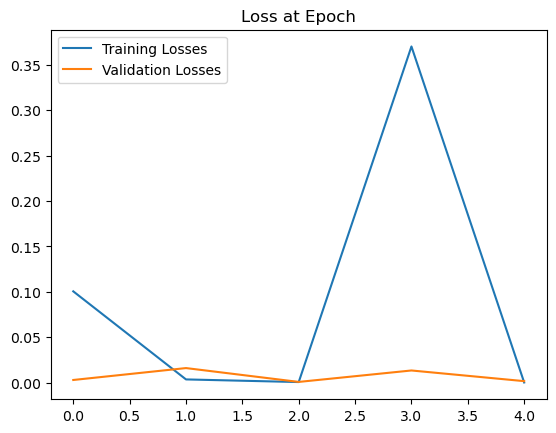

In [34]:
# let's plot loss at each epoch
# train_losses = [tl.detach().numpy() for tl in train_losses]
plt.plot(train_losses, label="Training Losses")
plt.plot(test_losses, label="Validation Losses")
plt.title("Loss at Epoch")
plt.legend()


Text(0.5, 1.0, 'Accuracy at the end of each Epoch')

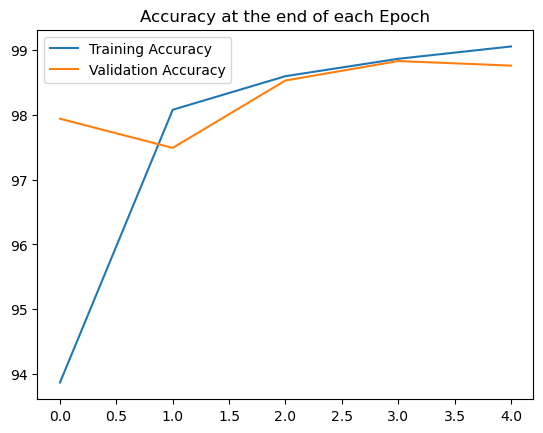

In [39]:
# graphing the accuracy 
plt.plot([t/600 for t in train_correct],label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy at the end of each Epoch")

In [45]:
# Testing for all test data

In [40]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [42]:
with torch.no_grad():
    correct = 0
    for X_test, y_test, in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [44]:
correct.item()/len(test_data)*100

98.76

In [46]:
# Gram an image
test_data[4150]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [47]:
# grab just the data
test_image = test_data[4150][0] 

In [50]:
# reshpe it
test_image = test_image.reshape(28,28)

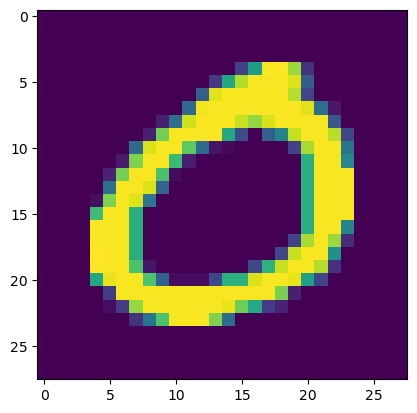

In [51]:
# Shoe the image
plt.imshow(test_image)

In [53]:
# passing the image through the model
with torch.no_grad():
    newPred = model(test_image.view(1,1,28,28))

In [ ]:
ne